<a href="https://colab.research.google.com/github/HeytorAlves/CartorioEbac/blob/main/C%C3%B3pia_de_projeto_image_similarity_recommendations_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 171s 526ms/step - accuracy: 0.7696 - loss: 0.5701 - val_accuracy: 0.8687 - val_loss: 0.3069
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 564ms/step - accuracy: 0.8705 - loss: 0.3084 - val_accuracy: 0.8813 - val_loss: 0.2953
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 567ms/step - accuracy: 0.8832 - loss: 0.2776 - val_accuracy: 0.8800 - val_loss: 0.2877
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 176s 564ms/step - accuracy: 0.8952 - loss: 0.2507 - val_accuracy: 0.8830 - val_loss: 0.2813
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 189s 524ms/step - accuracy: 0.9058 - loss: 0.2310 - val_accuracy: 0.8825 - val_loss: 0.2828


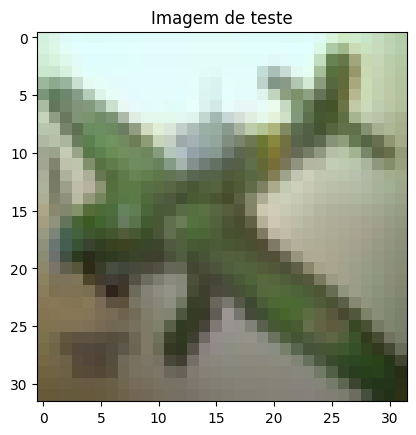

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe predita: avião


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1. Carregar dataset (CIFAR-10)
# ---------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# CIFAR-10 tem 10 classes, escolhemos apenas 4:
# 0=avião, 1=carro, 3=gato, 5=cachorro
classes_escolhidas = [0, 1, 3, 5]
nomes_classes = {0: "avião", 1: "carro", 3: "gato", 5: "cachorro"}

# Filtrar dataset para apenas as classes escolhidas
def filtrar_classes(x, y):
    mask = np.isin(y, classes_escolhidas).flatten()
    x, y = x[mask], y[mask]
    # Remapear labels para 0..3
    y = np.array([classes_escolhidas.index(label[0]) for label in y])
    return x, y

x_train, y_train = filtrar_classes(x_train, y_train)
x_test, y_test = filtrar_classes(x_test, y_test)

# Normalizar
x_train, x_test = x_train / 255.0, x_test / 255.0

# ---------------------------------------------------
# 2. Criar modelo (Transfer Learning com MobileNetV2)
# ---------------------------------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Congelar pesos da base

model = models.Sequential([
    layers.Resizing(96, 96),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")  # 4 classes
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# ---------------------------------------------------
# 3. Treinar
# ---------------------------------------------------
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test))

# ---------------------------------------------------
# 4. Testar com uma imagem nova
# ---------------------------------------------------
idx = 10
img = x_test[idx]
plt.imshow(img)
plt.title("Imagem de teste")
plt.show()

pred = model.predict(np.expand_dims(img, axis=0))
classe_predita = np.argmax(pred)
print("Classe predita:", nomes_classes[classes_escolhidas[classe_predita]])


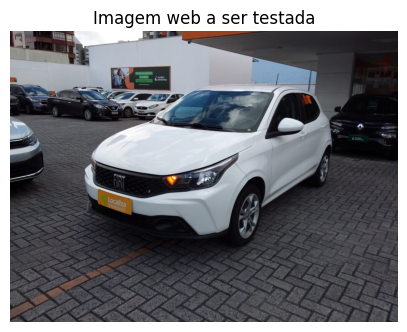

Similaridades (cosine) com cada classe:
  carro   : 0.5445
  avião   : 0.3992
  gato    : 0.3803
  cachorro : 0.3791

Classe mais similar: carro


In [ ]:
# Colab-ready. Roda em CPU/GPU. Resultado: similaridade entre imagem web e 4 classes (avião, carro, gato, cachorro).
!pip install pillow numpy matplotlib

import tensorflow as tf
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# === CONFIG ===
WEB_IMAGE_URL = "https://cdn-site-seminovos.localiza.com/prd/site/anuncio/272088/fiat-argo-drive-10-6v-flex-4p-car-2024-branco-manual-seminovo-272088-90303d83-9405-44c0-9e33-2fa86b16702e-1.jpg"  # substitua pela url que quiser
TARGET_SIZE = (96,96)   # tamanho compatível com MobileNetV2 resizing no pipeline
CLASSES_IDX = {0:"avião", 1:"carro", 2:"gato", 3:"cachorro"}  # rótulos remapeados (CIFAR subset)

# === 1) Preparar modelo de embeddings (MobileNetV2 pré-treinado ImageNet) ===
base = tf.keras.applications.MobileNetV2(input_shape=(96,96,3), include_top=False, weights="imagenet")
model_emb = tf.keras.Sequential([
    layers.Resizing(96,96),
    base,
    layers.GlobalAveragePooling2D()
])
model_emb.trainable = False

# Função de preprocess compatível com MobileNetV2
def preprocess_pil(img_pil):
    img = img_pil.convert("RGB").resize(TARGET_SIZE)
    arr = np.array(img).astype("float32")
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)  # normalização adequada
    return arr

# === 2) Carregar CIFAR-10 e filtrar as 4 classes escolhidas (0=airplane,1=automobile,3=cat,5=dog) ===
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
chosen = [0,1,3,5]
def filter_and_remap(x,y):
    mask = np.isin(y, chosen).flatten()
    xf = x[mask]
    yf_raw = y[mask].flatten()
    # remap labels para 0..3 conforme chosen order
    ym = np.array([chosen.index(v) for v in yf_raw])
    return xf, ym

x_train4, y_train4 = filter_and_remap(x_train, y_train)
x_test4, y_test4 = filter_and_remap(x_test, y_test)

# === 3) Criar protótipos (embedding médio) por classe usando imagens de treino ===
def batch_embeddings(images):
    # images: uint8 0-255
    imgs = [Image.fromarray(img) for img in images]
    arr = np.stack([preprocess_pil(im) for im in imgs], axis=0)
    emb = model_emb.predict(arr, verbose=0)
    return emb

# Calcula embedding por classe (média)
prototypes = []
for cls in range(4):
    imgs_cls = x_train4[y_train4==cls]
    emb_cls = batch_embeddings(imgs_cls)
    proto = emb_cls.mean(axis=0)
    prototypes.append(proto)
prototypes = np.stack(prototypes, axis=0)  # shape (4, D)

# normalize prototypes
p_norm = prototypes / (np.linalg.norm(prototypes, axis=1, keepdims=True) + 1e-10)

# === 4) Baixar imagem da web, mostrar e extrair embedding ===
resp = requests.get(WEB_IMAGE_URL, timeout=15)
resp.raise_for_status()
img_web = Image.open(BytesIO(resp.content)).convert("RGB")
plt.figure(figsize=(5,5))
plt.imshow(img_web)
plt.axis("off")
plt.title("Imagem web a ser testada")
plt.show()

arr_web = preprocess_pil(img_web)
emb_web = model_emb.predict(np.expand_dims(arr_web, axis=0), verbose=0)[0]
emb_web_norm = emb_web / (np.linalg.norm(emb_web) + 1e-10)

# === 5) Calcular similaridade (cosine) entre imagem web e cada protótipo ===
cos_sim = (p_norm @ emb_web_norm).astype(float)  # dot product = cosine since both normalized
# ordenar por similaridade decrescente
order = np.argsort(-cos_sim)

print("Similaridades (cosine) com cada classe:")
for idx in order:
    print(f"  {CLASSES_IDX[idx]:7s} : {cos_sim[idx]:.4f}")

best = order[0]
print("\nClasse mais similar:", CLASSES_IDX[best])

# === 6) Opcional: mostrar as 5 imagens de treino mais próximas da classe prevista (por embedding) ===
# extrair embeddings das imagens de treino da classe prevista e mostrar as top5 por cosine com emb_web
imgs_pred_cls = x_train4[y_train4==best]
embs_pred_cls = batch_embeddings(imgs_pred_cls)
embs_pred_norm = embs_pred_cls / (np.linalg.norm(embs_pred_cls, axis=1, keepdims=True)+1e-10)
sims = embs_pred_norm @ emb_web_norm
top5 = np.argsort(-sims)[:5]

plt.figure(figsize=(12,3))
for i, idx_img in enumerate(top5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs_pred_cls[idx_img])
    plt.title(f"sim={sims[idx_img]:.3f}")
    plt.axis("off")
plt.suptitle(f"Top-5 imagens de treino mais próximas da classe '{CLASSES_IDX[best]}'")
plt.show()
